In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

# Import Tools
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

# Visualizer
# Heavily based on https://github.com/Prodicode/ann-visualizer
def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [2]:
# Load and show data
df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Get only Important ones from these poss
# ['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'is_recid', 
#         'is_violent_recid', 'decile_score', 'decile_score.1', 'score_text', 'v_decile_score', 'v_score_text', 'priors_count.1', 'event', 'two_year_recid']
cols = ['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']
df = df[cols]
df = df.dropna(how='any')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


In [4]:
# Replace text with numbers
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


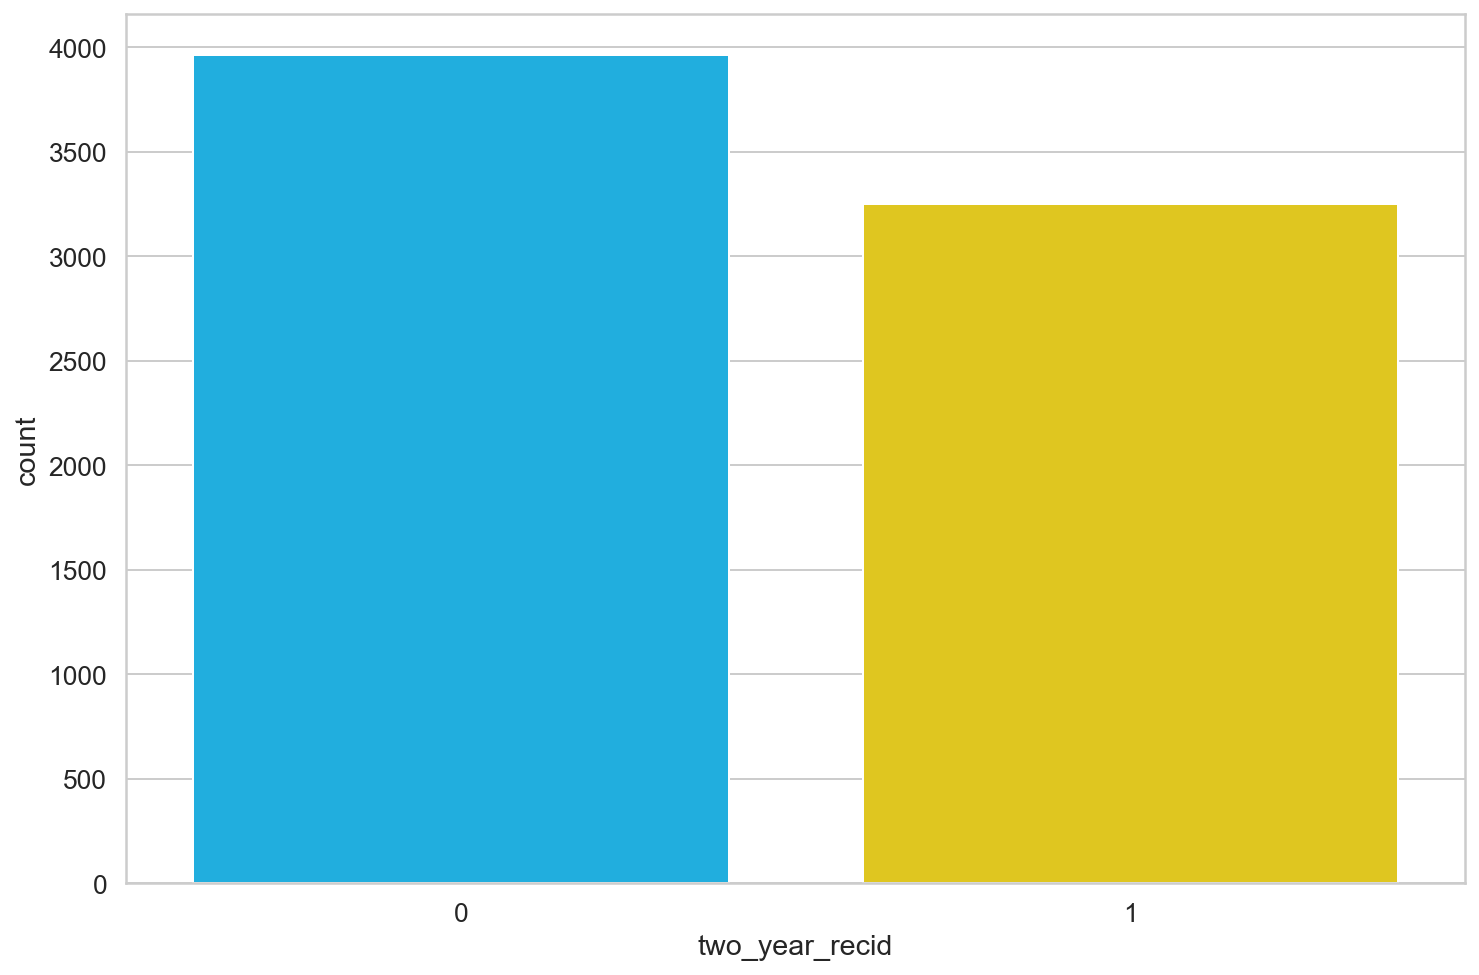

In [5]:
# Plot ground truth
sns.countplot(df.two_year_recid);

In [6]:
# Percentage ground truth
df.two_year_recid.value_counts() / df.shape[0]

0    0.549348
1    0.450652
Name: two_year_recid, dtype: float64

In [7]:
# Split data
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# To tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5771, 10]) torch.Size([5771])
torch.Size([1443, 10]) torch.Size([1443])


In [8]:
# Define the model
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [9]:
ann_viz(net, view=False)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)

criterion = criterion.to(device)
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1200):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

# Save model
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

epoch 0
Train set - loss: 0.742, accuracy: 0.544
Test  set - loss: 0.73, accuracy: 0.57

epoch 100
Train set - loss: 0.644, accuracy: 0.586
Test  set - loss: 0.636, accuracy: 0.611

epoch 200
Train set - loss: 0.542, accuracy: 0.754
Test  set - loss: 0.532, accuracy: 0.782

epoch 300
Train set - loss: 0.44, accuracy: 0.844
Test  set - loss: 0.43, accuracy: 0.86

epoch 400
Train set - loss: 0.346, accuracy: 0.897
Test  set - loss: 0.336, accuracy: 0.905

epoch 500
Train set - loss: 0.297, accuracy: 0.906
Test  set - loss: 0.285, accuracy: 0.911

epoch 600
Train set - loss: 0.279, accuracy: 0.906
Test  set - loss: 0.267, accuracy: 0.911

epoch 700
Train set - loss: 0.274, accuracy: 0.906
Test  set - loss: 0.262, accuracy: 0.912

epoch 800
Train set - loss: 0.272, accuracy: 0.907
Test  set - loss: 0.26, accuracy: 0.912

epoch 900
Train set - loss: 0.271, accuracy: 0.907
Test  set - loss: 0.259, accuracy: 0.913

epoch 1000
Train set - loss: 0.27, accuracy: 0.907
Test  set - loss: 0.259, ac

D:\conda\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:
# Test the model using test set
net = torch.load(MODEL_PATH)
classes = ['No Recid', 'Recid']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " + str(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

    No Recid       0.89      0.96      0.93       823
       Recid       0.94      0.85      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy : 0.9126819126819127


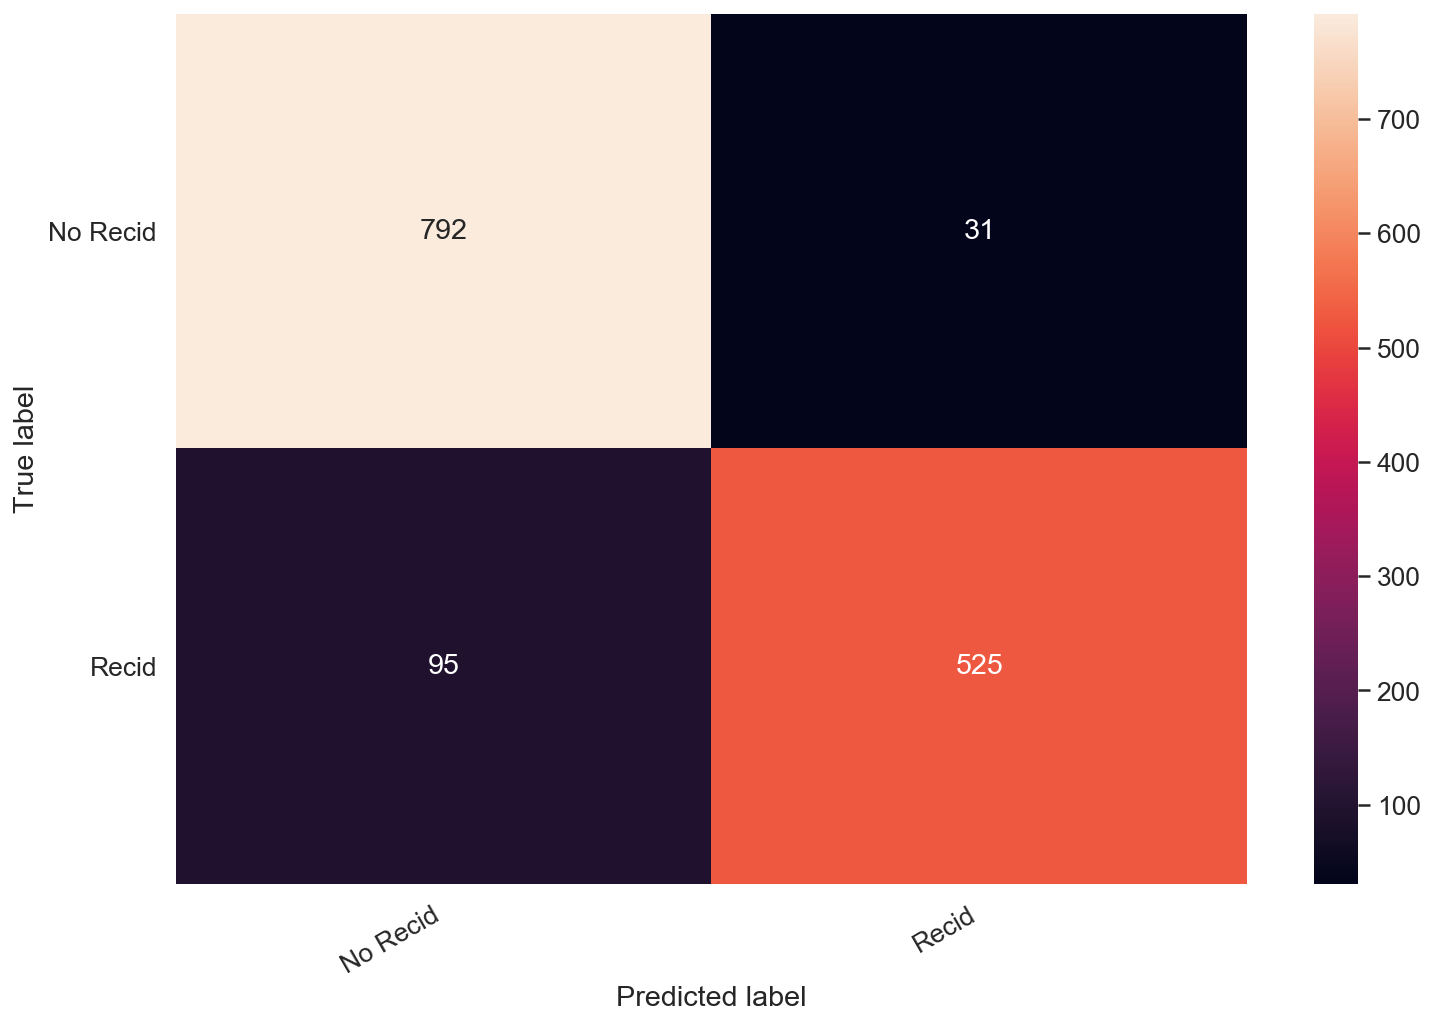

In [11]:
# Plot
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [12]:
# Make a Prediction
def will_recid(sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event):
  t = torch.as_tensor([sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

# Possible values
print("sex : " + str(df.sex.unique()))
print("race : " + str(df.race.unique()))
print("age_cat : " + str(df.age_cat.unique()))
print("juv_fel_count : " + str(df.juv_fel_count.unique()))
print("juv_misd_count : " + str(df.juv_misd_count.unique()))
print("priors_count : " + str(df.priors_count.unique()))
print("c_charge_degree : " + str(df.c_charge_degree.unique()))
print("is_violent_recid : " + str(df.is_violent_recid.unique()))
print("v_decile_score : " + str(df.v_decile_score.unique()))
print("event : " + str(df.event.unique()))

sex : [1 2]
race : [1 2 3 4 5 6]
age_cat : [1 2 3]
juv_fel_count : [ 0  2  1  8  4  3  9 20  6  5 10]
juv_misd_count : [ 0  1  6 12  2  4  3  8  5 13]
priors_count : [ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
c_charge_degree : [1 2]
is_violent_recid : [0 1]
v_decile_score : [ 1  3  6  2  5  4  9  7 10  8]
event : [0 1]


In [13]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=6, priors_count =14, c_charge_degree =1, is_violent_recid =1, v_decile_score =3, event= 0)

True

In [14]:
will_recid(sex=1, race= 6, age_cat=3, juv_fel_count=0, juv_misd_count=0, priors_count =0, c_charge_degree =1, is_violent_recid =0, v_decile_score =1, event= 0)

False